In [2]:
%load_ext autoreload
%autoreload 2

from torch import nn
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
from TCN_jordan import *

In [3]:
# data=pd.read_csv(r'Dataset/exchange_rate.csv')
# data_set_train,data_set_test = data.iloc[:-34,:],data.iloc[-34:,:]

In [4]:

data_set = pd.read_csv(r'Dataset/exchange_rate.csv')
train_val_data = data_set[: int(0.99 * len(data_set))]

validation_data = train_val_data[int(0.8 * len(train_val_data)):].copy()
train_data = train_val_data[: int(0.8 * len(train_val_data))]

test_data = data_set[int(0.95 * len(data_set)):]

In [5]:
model = PSTA_TCN(
window_size=10,
kernel_size=9,
n_hidden_layers=5,
n_hidden_dimensions=5,
n_signals=8,
prediction_horizon=2,
batch_size=100,
patience=25,
lr=1e-5,
nb_epochs=500,
)


# model.fit(train_data,validation_data)

In [6]:
def objective(trial):

    try:

        # Instantiate your ElectricNet model with the sampled hyperparameters
        window_size = trial.suggest_int('window_size', 5, 30)
        kernel_size = 2*trial.suggest_int('kernel_size', 1, 5)+1
        n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 3)
        n_hidden_dimensions = trial.suggest_int('n_hidden_dimensions', 1, 8)
        
        # n_signals = trial.suggest_int('n_signals', 1, 10)
        prediction_horizon = 3 #trial.suggest_int('prediction_horizon', 1, 2)
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
        batch_size = trial.suggest_int('batch_size', 16, 128)
        
        patience = 30 #trial.suggest_int('patience', 10, 30)
        conv_dilatation = 1 #trial.suggest_int('conv_dilatation', 1, 1) 
        
        # TODO : - Conv dilation il l'a enforcé à 1 - kernel size est obligé d'être impair à cause de comment il set le padding - les index à prendre ca doit etre dim_points_df-prediction_horizon+1 - revoir la relation windows size et training - check l'architecture
        
        
        nb_epochs = trial.suggest_int('nb_epochs', 50, 200)
    
        # Create an instance of the PSTA_TCN model with the sampled hyperparameters
        model = PSTA_TCN(
            window_size=window_size,
            kernel_size=kernel_size,
            n_hidden_layers=n_hidden_layers,
            n_hidden_dimensions=n_hidden_dimensions,
            n_signals=n_signals,
            prediction_horizon=prediction_horizon,
            lr=lr,
            dropout_rate=dropout_rate,
            batch_size=batch_size,
            nb_epochs=nb_epochs,
            patience=patience,
            conv_dilatation=conv_dilatation
        )        


        model.fit(train_data, validation_data)

        points=predict_fn(model,data_set)
        df_points=pd.DataFrame(points.detach().numpy())
        df_points[0]=df_points[0].astype('int')
        df_points= df_points.groupby(0).mean()
        


        return np.linalg.norm(data_set.iloc[df_points.index-2,0].values.flatten()-df_points.values.flatten())


    except Exception as e:
        raise optuna.exceptions.TrialPruned(f'Skipping this trial due to an error: {str(e)}')
    


In [7]:
def run_optuna():

    study = optuna.create_study()
    study.optimize(objective, n_trials=50)
    
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))

    print("Best trial:")

    study.trials_dataframe().to_excel(r'/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/result_summary.xlsx')
    fig = optuna.visualization.plot_param_importances(study)
    fig.write_image(r"/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/fig_params.png", format='png', engine='kaleido')
    fig = optuna.visualization.plot_optimization_history(study)
    fig.write_image(r"/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/fig_history.png", format='png', engine='kaleido')


    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    best_num=list(study.trials_dataframe().sort_values(by='value', ascending=False)[:5]['number'])
    print(best_num)


In [ ]:
run_optuna()

[I 2023-12-17 14:24:31,418] A new study created in memory with name: no-name-96ed6c31-b687-49b9-94b5-7958595a3e08
[I 2023-12-17 14:24:31,418] A new study created in memory with name: no-name-96ed6c31-b687-49b9-94b5-7958595a3e08
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_59948/4029309941.py:6: FutureWarning:

suggest_int(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_59948/4029309941.py:7: FutureWarning:

suggest_int(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_59948/4029309941.py:8: FutureWarning:

suggest_int(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_59948/4029309941.py:9: FutureWarning:

suggest_int

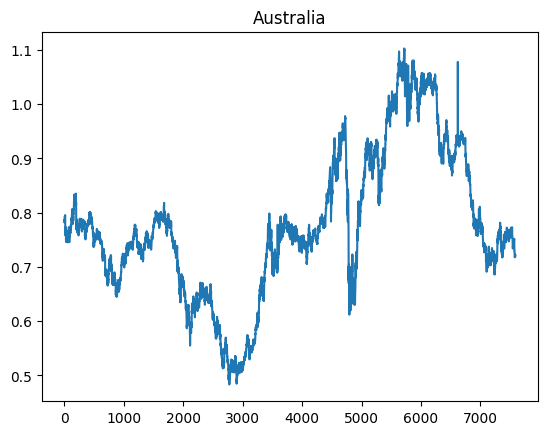

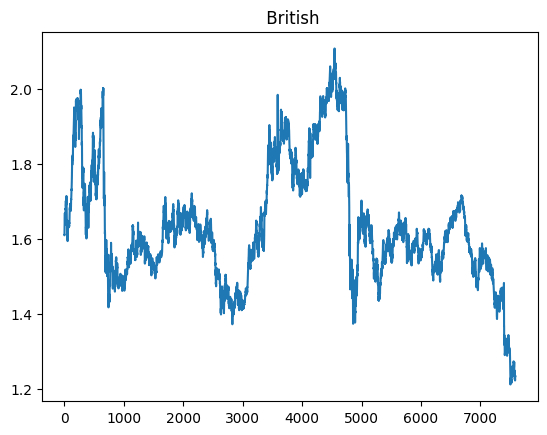

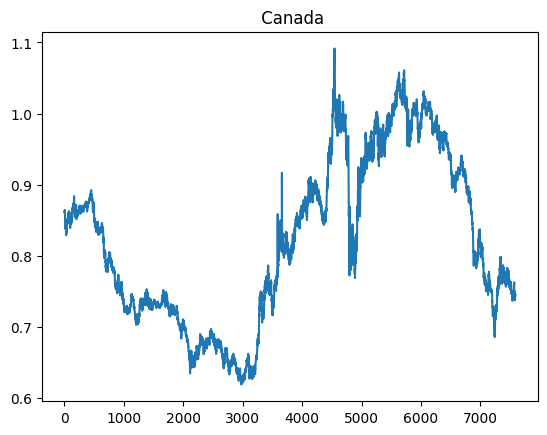

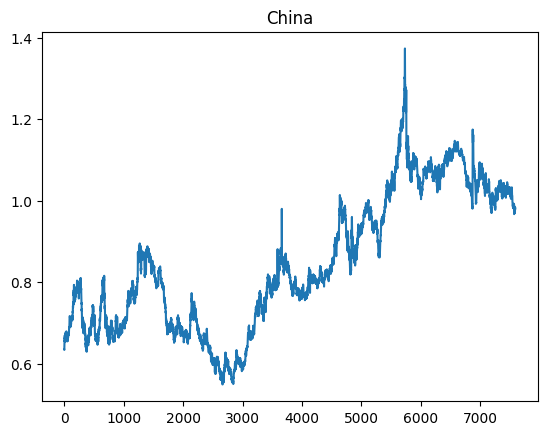

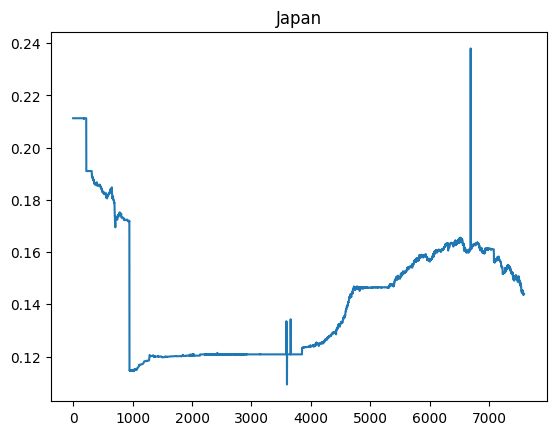

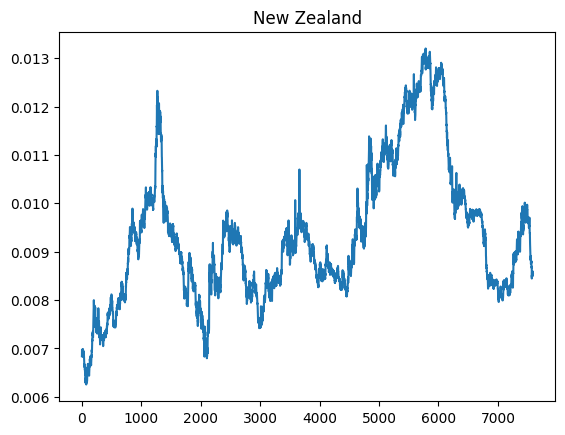

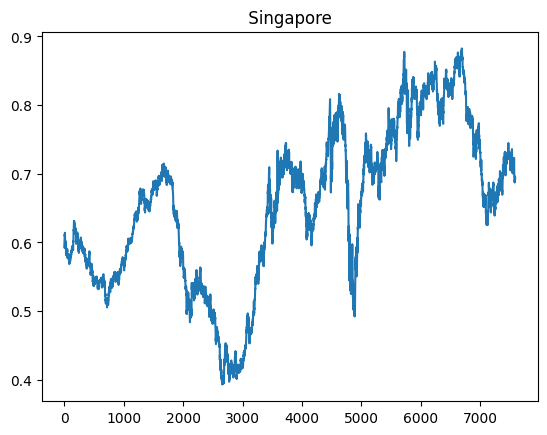

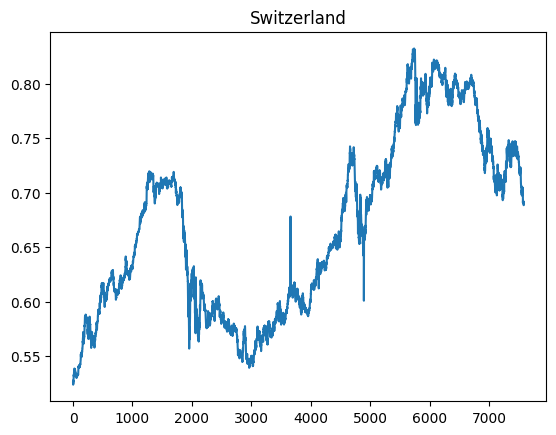

In [8]:
for col in data_set.columns:
        data_set[col].plot(title=col)
        plt.show()

In [9]:
def predict_fn(model,dataset):
        prediction_horizon=model.tau
        window_size=model.T 
        train_set = torch.from_numpy(dataset.astype('float32').values)
        train_data = [train_set[i: i + window_size] for i in range(len(train_set) - window_size)]
        point_to_plot=[]
        for i,x in enumerate(train_data):
                predictions=model.predict(x)
                point_to_plot+=[torch.Tensor([v,predictions.squeeze()[k]]) for k,v in enumerate(np.arange(i+window_size,i+window_size+prediction_horizon))]
        
        point_to_plot=torch.stack(point_to_plot)
        
        return point_to_plot
  

In [11]:
model_2= PSTA_TCN(
window_size=55,
kernel_size=5,
n_hidden_layers=3,
n_hidden_dimensions=5,
n_signals=8,
prediction_horizon=3,
batch_size=82,
patience=25,
lr=9.177087709816208e-05,
nb_epochs=100,
number_TCN=3,
dropout_rate=0.05,
seed=55,
)


model_2.fit(train_data,validation_data)

Random self.seed set as 55
trigger times: 0
epochs 0: training_loss: 0.5764010083185483, validation_loss:0.6433809366491106 	
trigger times: 0
epochs 1: training_loss: 0.25509174760073833, validation_loss:0.1750067878100607 	
trigger times: 0
epochs 2: training_loss: 0.1372222167580095, validation_loss:0.11925537967019612 	


KeyboardInterrupt: 

In [145]:
points=predict_fn(model,data_set,prediction_horizon,window_size=10)


In [65]:
plt.scatter(x=points[:,0],y=points[:,1],label='predicted_points')
data_set.iloc[:,0].plot(label='real_curve',color='red')
plt.legend()

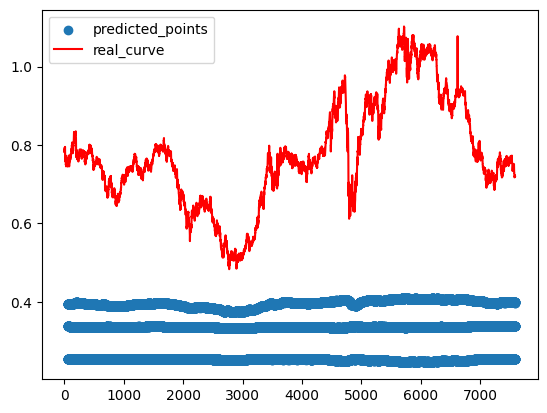

In [66]:
points=predict_fn(model,data_set,prediction_horizon,window_size=40)

In [165]:
points=predict_fn(model,data_set,prediction_horizon,window_size=40)
df_points=pd.DataFrame(points.detach().numpy())
df_points[0]=df_points[0].astype('int')
df_points= df_points.groupby(0).mean()
np.linalg.norm(data_set.iloc[df_points.index-1,0].values.flatten()-df_points.values.flatten())

7587

In [177]:
np.linalg.norm(data_set.iloc[df_points.index-1,0].values.flatten()-df_points.values.flatten())

12.696516753035064

In [162]:
data_set

,Australia,British,Canada,China,Japan,New Zealand,Singapore,Switzerland
0,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.593000,0.525486
1,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.594000,0.523972
2,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.597300,0.526316
3,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.597000,0.523834
4,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.598500,0.527426
...,...,...,...,...,...,...,...,...
7583,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.690846,0.688565
7584,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.695701,0.690288
7585,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.695943,0.691419
7586,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.692689,0.690942
